**Spatial Estimation**


# IDW

In [1]:
import geostatspy.GSLIB as GSLIB                       #GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                 #GSLIB methods convert to Python
import os                                               #to set current working directory 
import numpy as np                                      #arrays and matrix math
import pandas as pd                                     #DataFrames
import matplotlib.pyplot as plt  # plotting

## Question 1: Directory Creation

In [2]:
current_directory = os.getcwd()                                   #set the working directory
current_directory

'C:\\Users\\mademow\\Desktop\\Marsha\\GEOL\\Week4\\Homework'

In [3]:
#Creating path
import warnings
warnings.filterwarnings("ignore")
current_path = os.getcwd()


#Path for the images directory
image_path = 'Images'
results_path = 'Results'

#Check if the images directory already exists
if not os.path.exists(image_path):
    #Create the images directory
    os.mkdir(image_path)
else:
    print('Image directory already exists')

#Check if the file directory already exists
if not os.path.exists(results_path):
    # Create the file directory
    os.mkdir(results_path)
else:
    print('File directory already exists')

print('Image directory is -', image_path)
print('File directory is -', results_path)

Image directory is - Images
File directory is - Results


In [4]:
df = pd.read_csv(current_directory+"/sample_data_MV_biased.csv")                     #read a .csv file in as a DataFrame
df.head()                                                

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,0,100.0,900.0,0.0,0.101319,1.996868,5590.417154
1,1,100.0,800.0,1.0,0.147676,10.711789,3470.845666
2,2,100.0,700.0,1.0,0.145912,17.818143,3586.988513
3,3,100.0,600.0,1.0,0.186167,217.109365,3732.114787
4,4,100.0,500.0,1.0,0.146088,16.717367,2534.551236


In [5]:
df.describe().transpose()                          #summary table of all facies combined DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,368.0,293.260870,169.058258,0.000000,150.500000,296.000000,439.500000,586.000000
X,368.0,499.565217,289.770794,0.000000,240.000000,500.000000,762.500000,990.000000
Y,368.0,520.644022,277.412187,9.000000,269.000000,539.000000,769.000000,999.000000
Facies,368.0,0.597826,0.491004,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,368.0,0.127026,0.030642,0.041122,0.103412,0.125842,0.148623,0.210258
Perm,368.0,85.617362,228.362654,0.094627,2.297348,10.377292,50.581288,1991.097723
AI,368.0,4791.736646,974.560569,1981.177309,4110.728374,4713.325533,5464.043562,7561.250336


## Question 2: Saving Images

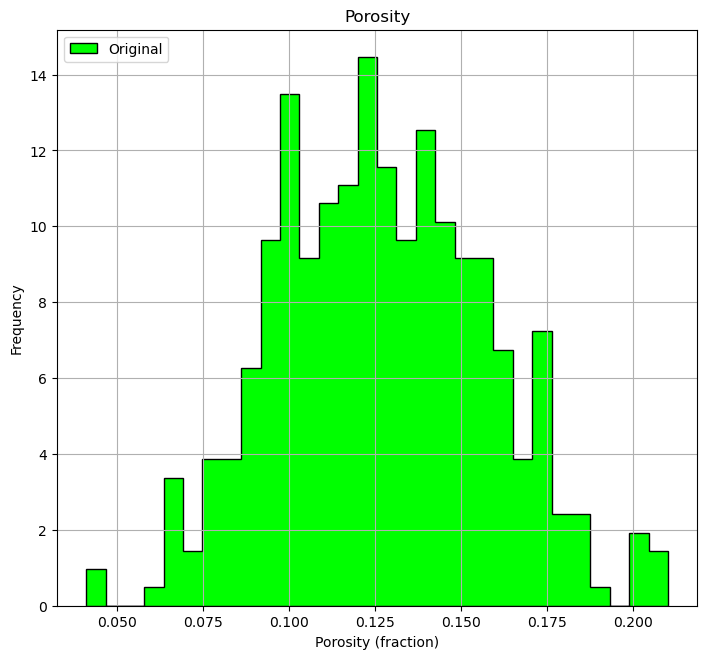

In [6]:
plt.subplot(111)                                        #plot original sand and shale porosity histograms
plt.hist(df['Porosity'], facecolor='lime',bins=30,histtype="stepfilled",alpha=1,density=True,cumulative=False,edgecolor='black',label='Original')

plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.3)

#Save the image as PNG at 300 dpi
plt.savefig(os.path.join(image_path, 'IDW1.png'), dpi=300)

#Save the image as PDF
plt.savefig(os.path.join(image_path, 'IDW1.pdf'))
plt.show()

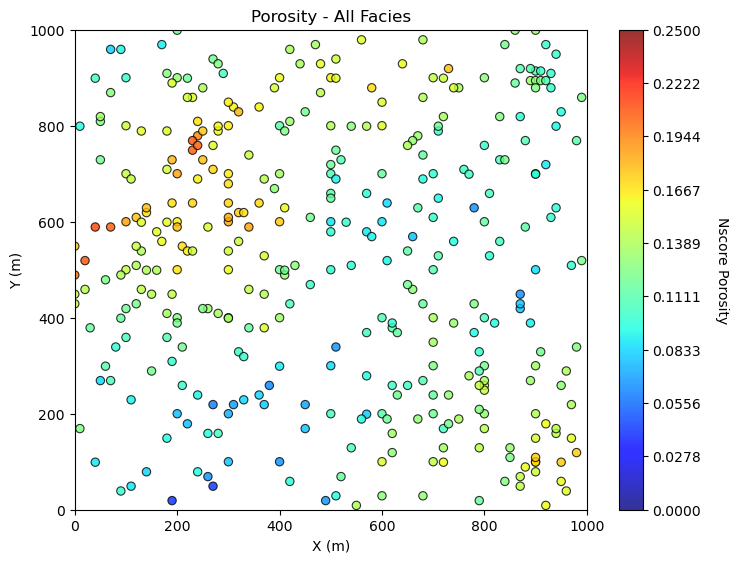

In [7]:
cmap = plt.cm.jet                #color map
plt.subplot(111)
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,0,0.25,'Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.5, hspace=0.3)
#Save the image as PNG at 300 dpi
plt.savefig(os.path.join(image_path, 'IDW2.png'), dpi=300)

#Save the image as PDF
plt.savefig(os.path.join(image_path, 'IDW2.pdf'))
plt.show()

In [8]:
import numpy as np
import scipy.spatial as sp

def invdist(df, xcol, ycol, vcol, tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power):
    """
    Inverse Distance to Python by Michael Pyrcz, the University of Texas at
    Austin (April, 2020). Based on modification of the GSLIB kb2d program by Deutsch and Journel (1997)
    
    :param df: pandas DataFrame with the spatial data
    :param xcol: name of the x coordinate column
    :param ycol: name of the y coordinate column
    :param vcol: name of the property column
    :param tmin: property trimming limit
    :param tmax: property trimming limit
    :param nx: definition of the grid system (x axis)
    :param xmn: definition of the grid system (x axis)
    :param xsiz: definition of the grid system (x axis)
    :param ny: definition of the grid system (y axis)
    :param ymn: definition of the grid system (y axis)
    :param ysiz: definition of the grid system (y axis)
    :param ndmin: minimum number of data points to use for kriging a block
    :param ndmax: maximum number of data points to use for kriging a block
    :param radius: maximum isotropic search radius
    :param power: the inverse distance power
    :return: estmap, an array with estimated values at each grid cell
    """
    #Constants
    UNEST = -999.
    EPSILON = 1.0e-10
    
    #Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]  #Trim values outside tmin and tmax
    nd = len(df_extract)
    ndmax = min(ndmax, nd)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values
    
    #Allocate the needed memory:
    xa = np.zeros(ndmax)
    ya = np.zeros(ndmax)
    vra = np.zeros(ndmax)
    dist = np.zeros(ndmax)
    nums = np.zeros(ndmax)
    s = np.zeros(ndmax)
    estmap = np.zeros((nx, ny))
    
    #Make a KDTree for fast search of nearest neighbors
    data_locs = np.column_stack((y, x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
    
    #Summary statistics for the data after trimming
    avg = vr.mean()
    stdev = vr.std()
    ss = stdev**2.0
    vrmin = vr.min()
    vrmax = vr.max()
    
    #Initialize accumulators
    rad2 = radius**2
    
    #MAIN LOOP OVER ALL THE BLOCKS IN THE GRID
    nk = 0
    ak = 0.0
    vk = 0.0
    for iy in range(0, ny):
        yloc = ymn + (iy - 0) * ysiz
        for ix in range(0, nx):
            xloc = xmn + (ix - 0) * xsiz
            current_node = (yloc, xloc)
            
            #Find the nearest samples within each octant: First initialize the counter arrays
            na = -1  #Accounting for 0 as the first index
            dist.fill(1.0e+20)
            nums.fill(-1)
            dist, nums = tree.query(current_node, ndmax)  #Use KD tree for fast nearest data search
            
            #Remove any data outside search radius
            nums = nums[dist < radius]
            dist = dist[dist < radius]
            nd = len(dist)
            
            #Is there enough samples?
            if nd < ndmin:  #Accounting for min index of 0
                est = UNEST
            else:
                #Put coordinates and values of neighborhood samples into xa, ya, vra
                for ia in range(0, nd):
                    jj = int(nums[ia])
                    xa[ia] = x[jj]
                    ya[ia] = y[jj]
                    vra[ia] = vr[jj]
                    
                #Solve for weights
                dist = np.sqrt((xa - xloc)**2 + (ya - yloc)**2)
                s = 1 / ((dist + EPSILON)**power)  #Calculate inverse weights
                s = s / np.sum(s)  #Constrain sum of the weights to 1.0 for unbiasedness
                est = 0.0
                for ia in range(0, nd):
                    est = est + s[ia] * vra[ia]
                    
            estmap[ny - iy - 1, ix] = est
            
            #Track the estimates
            if est > UNEST:
                nk = nk + 1
                ak = ak + est
                vk = vk + est**2
                
    #END OF MAIN LOOP OVER ALL THE BLOCKS
    
    if nk >= 1:
        ak = ak / float(nk)
        vk = vk / float(nk) - ak**2
        print('Estimated ' + str(nk) + ' blocks')
        print('Average ' + str(ak) + '  Variance ' + str(vk))
        
    return estmap


In [9]:
x = [100,600,800]; y = [100,500,700]; vr = [1.0,2.0,3.0]
dftest1 = pd.DataFrame({'X':x,'Y':y,'Var':vr})
tmin = -9999.9; tmax = 9999.9; 
nx = 1; xsiz = 10.0; xmn = 500
ny = 1; ysiz = 10.0; ymn = 500
ndmin = 1; ndmax = 100
radius = 1000.0; power = 2

invdist_est = invdist(dftest1,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power)
print('The single estimate at x = ' + str(xmn) + ', y = ' + str(ymn) + ' is ' + str(invdist_est[0][0]) + '.')

Estimated 1 blocks
Average 2.041214750542347  Variance 0.0
The single estimate at x = 500, y = 500 is 2.041214750542347.


Estimated 10000 blocks
Average 2.4785256874279527  Variance 0.18122365890746384
Estimated 10000 blocks
Average 2.4797288690464803  Variance 0.5062609912988218
Estimated 10000 blocks
Average 2.4893068152705276  Variance 0.7378534388298741


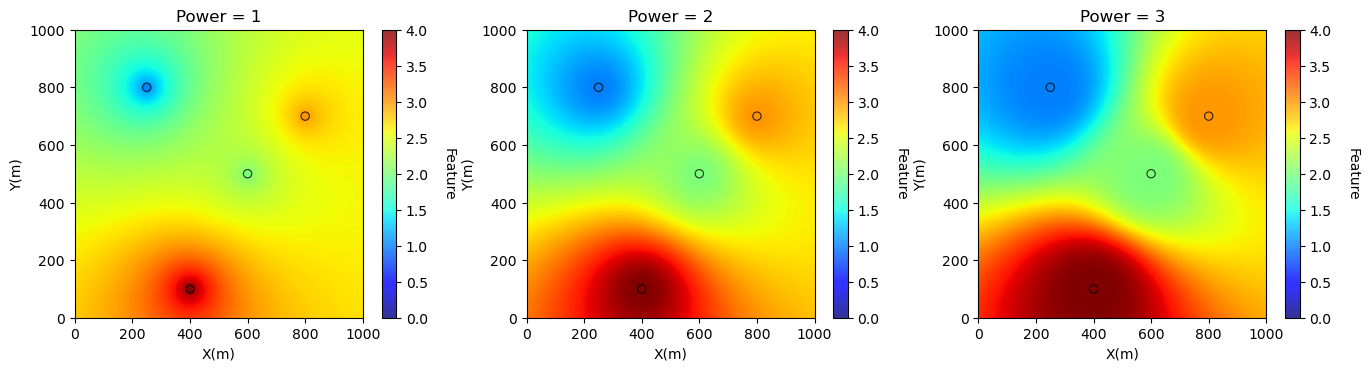

In [10]:
x = [250,600,800,400]; y = [800,500,700,100]; vr = [1.0,2.0,3.0,4.0]
dftest2 = pd.DataFrame({'X':x,'Y':y,'Var':vr})
tmin = -9999.9; tmax = 9999.9; 
nx = 100; xsiz = 10.0; xmn = 5.0; xmin = xmn - 0.5 * xsiz; xmax = xmin + nx * xsiz
ny = 100; ysiz = 10.0; ymn = 5.0; ymin = ymn - 0.5 * ysiz; ymax = ymin + ny * ysiz
ndmin = 1; ndmax = 100
radius = 10000.0; power = 2

invdist_map_power1 = invdist(dftest2,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power=1)
invdist_map_power2 = invdist(dftest2,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power=2)
invdist_map_power3 = invdist(dftest2,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power=3)

#plot the reuslting estimated maps
plt.subplot(131)
GSLIB.locpix_st(invdist_map_power1,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest2,'X','Y','Var','Power = 1','X(m)','Y(m)','Feature',cmap)

plt.subplot(132)
GSLIB.locpix_st(invdist_map_power2,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest2,'X','Y','Var','Power = 2','X(m)','Y(m)','Feature',cmap)

plt.subplot(133)
GSLIB.locpix_st(invdist_map_power3,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest2,'X','Y','Var','Power = 3','X(m)','Y(m)','Feature',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.6, wspace=0.2, hspace=0.2) 

#Save the image as PNG at 300 dpi
plt.savefig(os.path.join(image_path, 'IDW3.png'), dpi=300)

#Save the image as PDF
plt.savefig(os.path.join(image_path, 'IDW3.pdf'))
plt.show()

Estimated 10000 blocks
Average 2.4785256874279527  Variance 0.18122365890746384
Estimated 10000 blocks
Average 2.4797288690464803  Variance 0.5062609912988218
Estimated 10000 blocks
Average 2.4893068152705276  Variance 0.7378534388298741


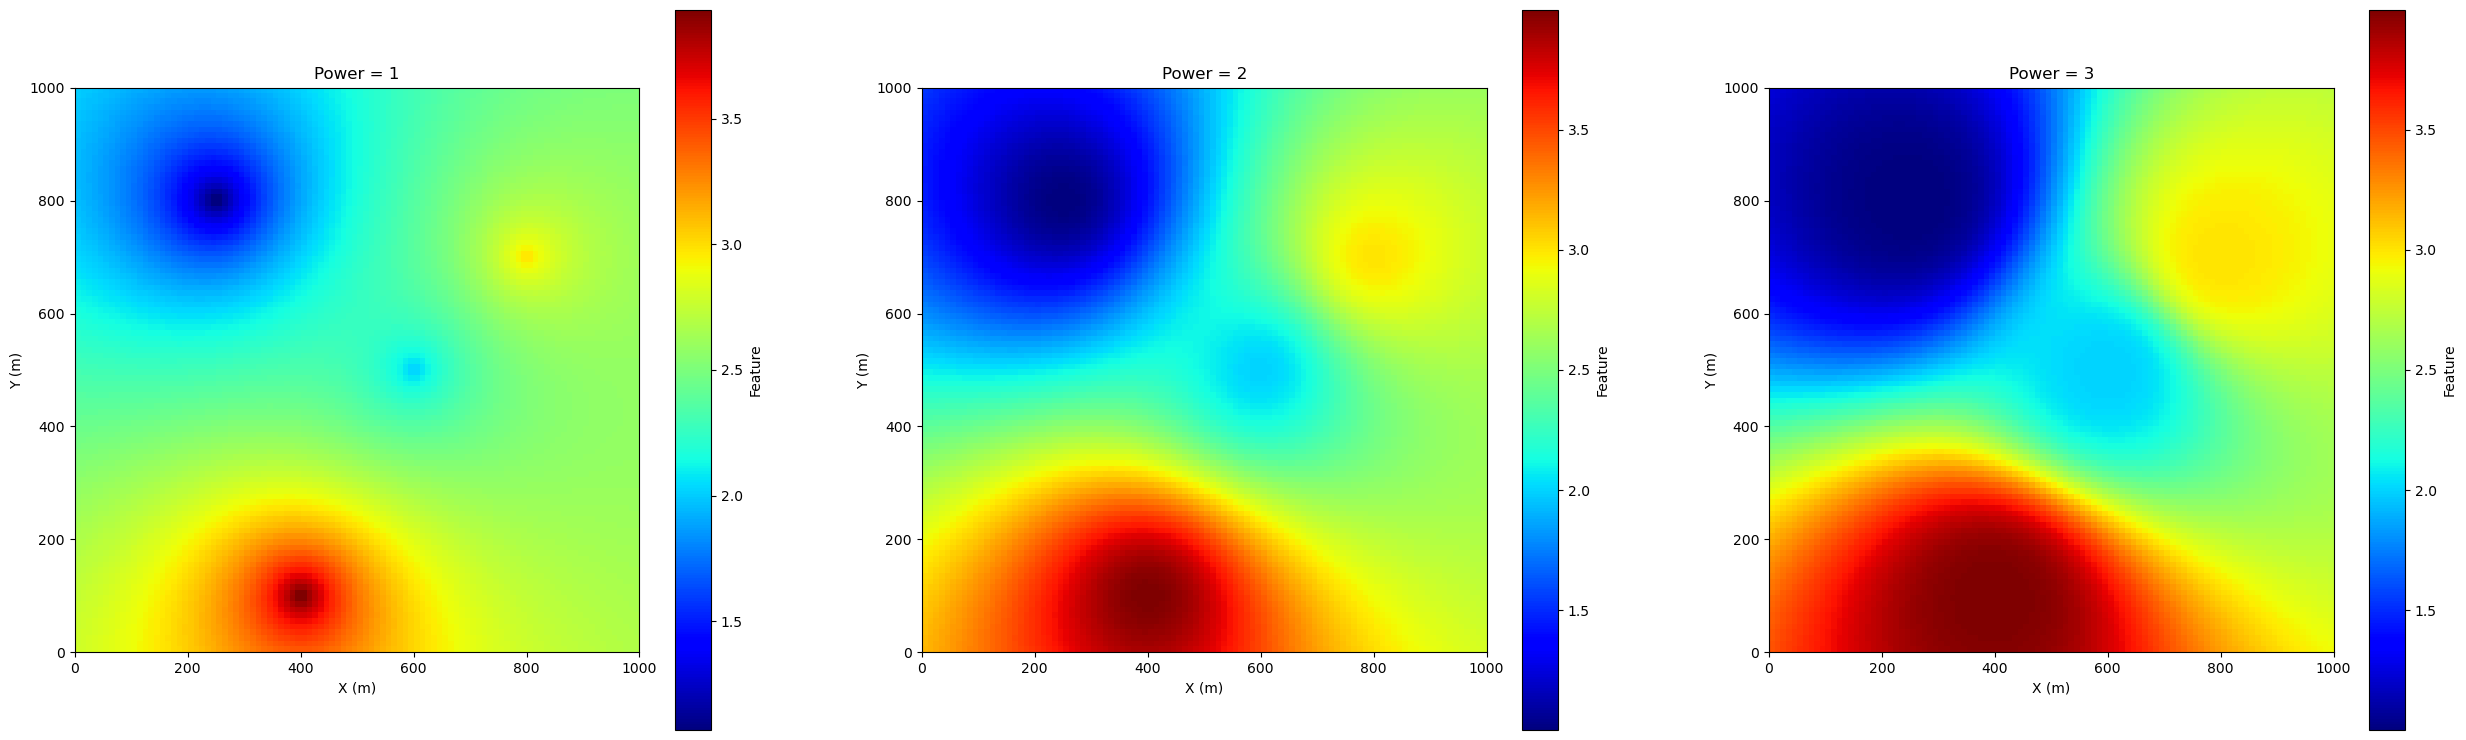

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Define the invdist function here

#Create the test DataFrame
x = [250, 600, 800, 400]
y = [800, 500, 700, 100]
vr = [1.0, 2.0, 3.0, 4.0]
dftest2 = pd.DataFrame({'X': x, 'Y': y, 'Var': vr})

#Parameters
tmin = -9999.9
tmax = 9999.9
nx = 100
xsiz = 10.0
xmn = 5.0
xmin = xmn - 0.5 * xsiz
xmax = xmin + nx * xsiz
ny = 100
ysiz = 10.0
ymn = 5.0
ymin = ymn - 0.5 * ysiz
ymax = ymin + ny * ysiz
ndmin = 1
ndmax = 100
radius = 10000.0
power = 2

#Calculate the estimated maps with different power values
invdist_map_power1 = invdist(dftest2, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power=1)
invdist_map_power2 = invdist(dftest2, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power=2)
invdist_map_power3 = invdist(dftest2, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power=3)

#Plot the resulting estimated maps
cmap = plt.get_cmap('jet')

plt.figure(figsize=(12, 12))

plt.subplot(131)
plt.imshow(invdist_map_power1, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Power = 1')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(132)
plt.imshow(invdist_map_power2, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Power = 2')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(133)
plt.imshow(invdist_map_power3, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Power = 3')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.6, wspace=0.2, hspace=0.2)

#Save the image as PNG at 300 dpi
plt.savefig(os.path.join(image_path, 'IDW4.png'), dpi=300)

#Save the image as PDF
plt.savefig(os.path.join(image_path, 'IDW4.pdf'))
plt.show()

Estimated 1264 blocks
Average 2.39116744243245  Variance 1.049982892969484
Estimated 9852 blocks
Average 1.8721620915639599  Variance 0.7914133099779668
Estimated 10000 blocks
Average 2.4797288690464803  Variance 0.5062609912988218


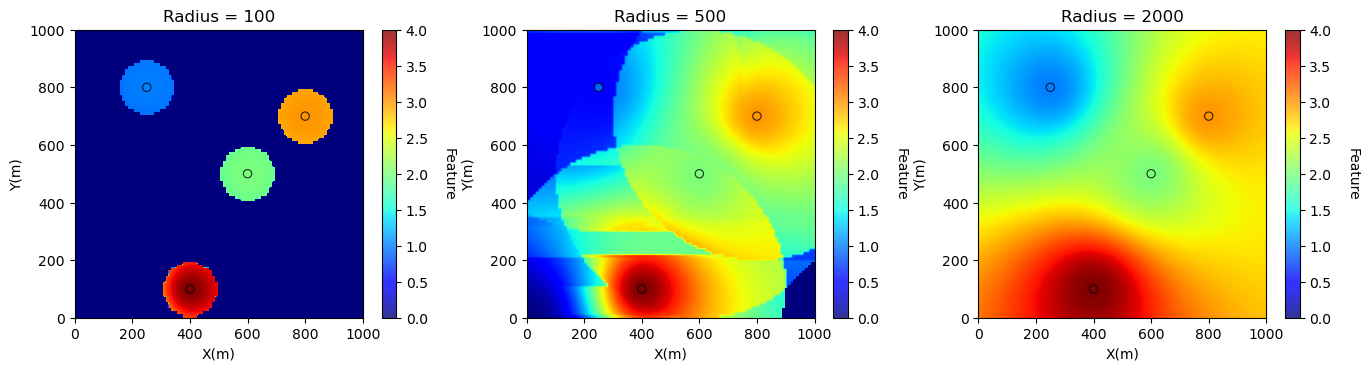

In [12]:
x = [250,600,800,400]; y = [800,500,700,100]; vr = [1.0,2.0,3.0,4.0]
dftest3 = pd.DataFrame({'X':x,'Y':y,'Var':vr})
tmin = -9999.9; tmax = 9999.9; 
nx = 100; xsiz = 10.0; xmn = 5.0; xmin = xmn - 0.5 * xsiz; xmax = xmin + nx * xsiz
ny = 100; ysiz = 10.0; ymn = 5.0; ymin = ymn - 0.5 * ysiz; ymax = ymin + ny * ysiz
ndmin = 1; ndmax = 100
power = 2

invdist_map_radius1 = invdist(dftest3,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius = 100,power=2)
invdist_map_radius2 = invdist(dftest3,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius = 500,power=2)
invdist_map_radius3 = invdist(dftest3,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius = 2000,power=2)

#plot the reuslting estimated maps
plt.subplot(131)
GSLIB.locpix_st(invdist_map_radius1,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest3,'X','Y','Var','Radius = 100','X(m)','Y(m)','Feature',cmap)

plt.subplot(132)
GSLIB.locpix_st(invdist_map_radius2,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest3,'X','Y','Var','Radius = 500','X(m)','Y(m)','Feature',cmap)

plt.subplot(133)
GSLIB.locpix_st(invdist_map_radius3,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest3,'X','Y','Var','Radius = 2000','X(m)','Y(m)','Feature',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.6, wspace=0.2, hspace=0.2)

#Save the image as PNG at 300 dpi
plt.savefig(os.path.join(image_path, 'IDW5.png'), dpi=300)

#Save the image as PDF
plt.savefig(os.path.join(image_path, 'IDW5.pdf'))
plt.show()

Estimated 1264 blocks
Average 2.39116744243245  Variance 1.049982892969484
Estimated 9852 blocks
Average 1.8721620915639599  Variance 0.7914133099779668
Estimated 10000 blocks
Average 2.4797288690464803  Variance 0.5062609912988218


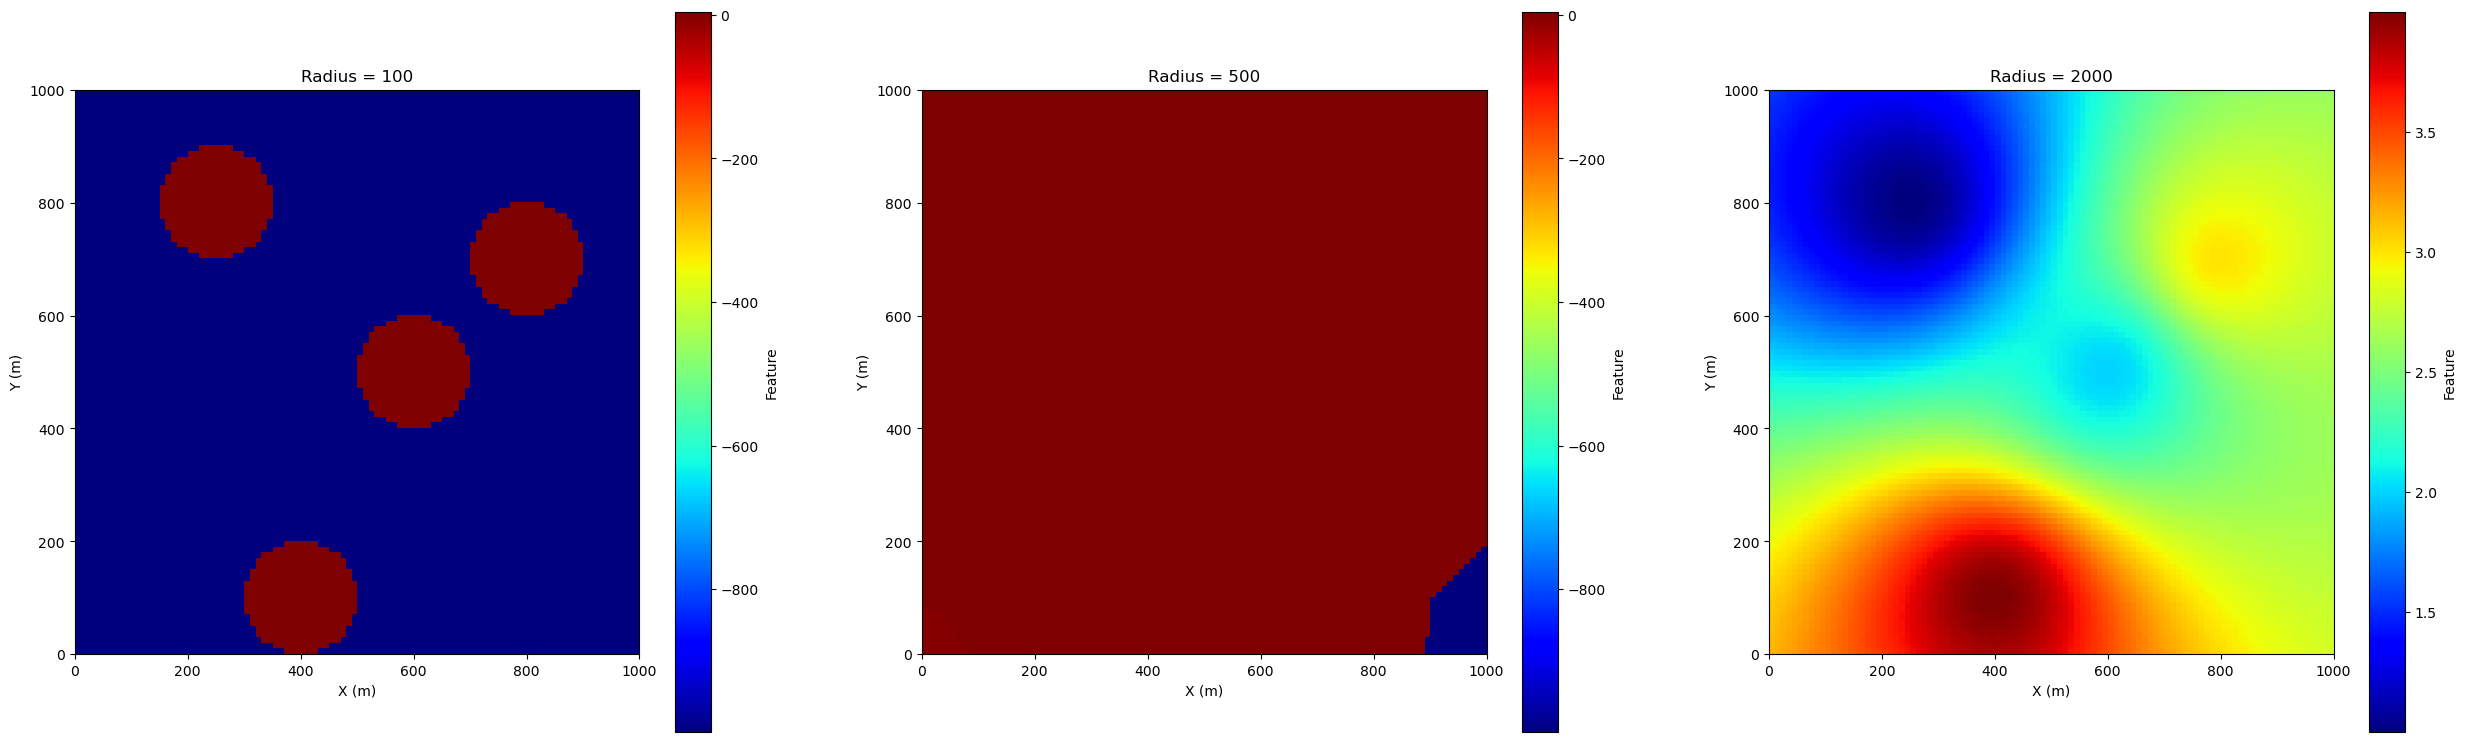

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Define the invdist function here

#Create the test DataFrame
x = [250, 600, 800, 400]
y = [800, 500, 700, 100]
vr = [1.0, 2.0, 3.0, 4.0]
dftest3 = pd.DataFrame({'X': x, 'Y': y, 'Var': vr})

#Parameters
tmin = -9999.9
tmax = 9999.9
nx = 100
xsiz = 10.0
xmn = 5.0
xmin = xmn - 0.5 * xsiz
xmax = xmin + nx * xsiz
ny = 100
ysiz = 10.0
ymn = 5.0
ymin = ymn - 0.5 * ysiz
ymax = ymin + ny * ysiz
ndmin = 1
ndmax = 100
power = 2

#Calculate the estimated maps with different radii
invdist_map_radius1 = invdist(dftest3, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius=100, power=2)
invdist_map_radius2 = invdist(dftest3, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius=500, power=2)
invdist_map_radius3 = invdist(dftest3, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius=2000, power=2)

#Plot the resulting estimated maps
cmap = plt.get_cmap('jet')

plt.figure(figsize=(12, 12))

plt.subplot(131)
plt.imshow(invdist_map_radius1, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Radius = 100')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(132)
plt.imshow(invdist_map_radius2, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Radius = 500')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(133)
plt.imshow(invdist_map_radius3, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Radius = 2000')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.6, wspace=0.2, hspace=0.2)

#Save the image as PNG at 300 dpi
plt.savefig(os.path.join(image_path, 'IDW6.png'), dpi=300)

#Save the image as PDF
plt.savefig(os.path.join(image_path, 'IDW6.pdf'))
plt.show()

Estimated 10000 blocks
Average 0.12259183265615498  Variance 0.0005453275015534012


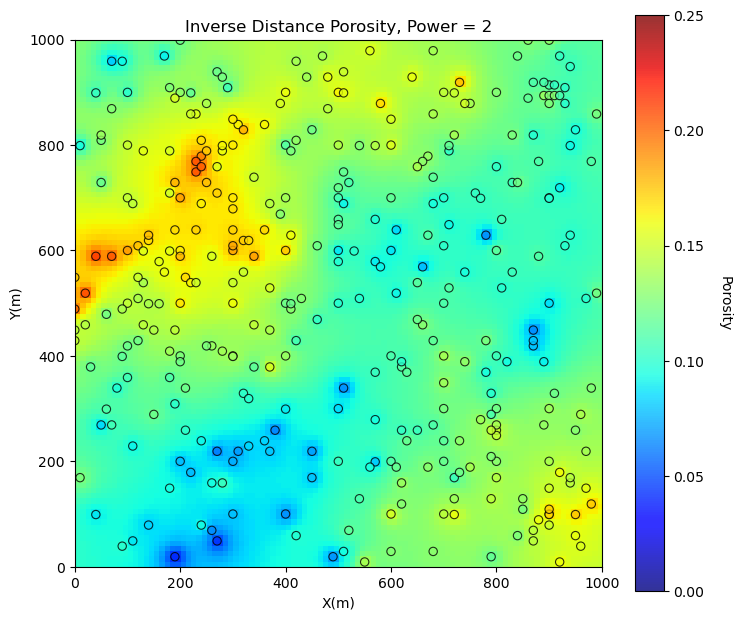

In [14]:
tmin = -9999.9; tmax = 9999.9; 
nx = 100; xsiz = 10.0; xmn = 5.0; xmin = xmn - 0.5 * xsiz; xmax = xmin + nx * xsiz
ny = 100; ysiz = 10.0; ymn = 5.0; ymin = ymn - 0.5 * ysiz; ymax = ymin + ny * ysiz
ndmin = 1; ndmax = 100
radius = 2000; power = 2

invdist_map_porosity = invdist(df,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power)

#plot the reuslting estimated maps
plt.subplot(131)
GSLIB.locpix_st(invdist_map_porosity,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df,'X','Y','Porosity','Inverse Distance Porosity, Power = ' + str(power),'X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=1.2, wspace=0.2, hspace=0.2)

#Save the image as PNG at 300 dpi
plt.savefig(os.path.join(image_path, 'IDW7.png'), dpi=300)

#Save the image as PDF
plt.savefig(os.path.join(image_path, 'IDW7.pdf'))
plt.show()

Estimated 10000 blocks
Average 0.12259183265615498  Variance 0.0005453275015534012


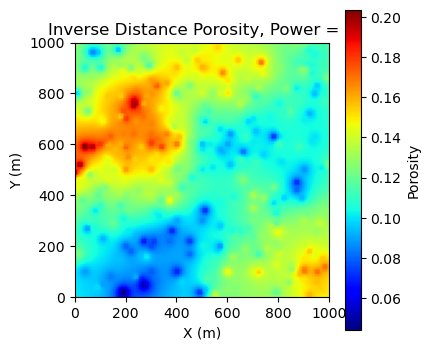

In [15]:
import matplotlib.pyplot as plt
import numpy as np

#Parameters
tmin = -9999.9
tmax = 9999.9
nx = 100
xsiz = 10.0
xmn = 5.0
xmin = xmn - 0.5 * xsiz
xmax = xmin + nx * xsiz
ny = 100
ysiz = 10.0
ymn = 5.0
ymin = ymn - 0.5 * ysiz
ymax = ymin + ny * ysiz
ndmin = 1
ndmax = 100
radius = 2000
power = 2

#Calculate the estimated map
invdist_map_porosity = invdist(df, 'X', 'Y', 'Porosity', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power)

#Plot the resulting estimated map
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(invdist_map_porosity, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap='jet')
plt.colorbar(label='Porosity')
plt.title('Inverse Distance Porosity, Power = ' + str(power))
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.9, wspace=0.2, hspace=0.2)
#Save the image as PNG at 300 dpi
plt.savefig(os.path.join(image_path, 'IDW8.png'), dpi=300)

#Save the image as PDF
plt.savefig(os.path.join(image_path, 'IDW8.pdf'))
plt.show()

## Question 3: IDW Estimation and Export

In [16]:
#Calculate the IDW estimate at power 2
power = 2
invdist_map_porosity_p2 = invdist(df, 'X', 'Y', 'Porosity', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power)

#Calculate the IDW estimate at power 3
power = 3
invdist_map_porosity_p3 = invdist(df, 'X', 'Y', 'Porosity', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power)

#Ensure the dimensions of the estimates match the grid
nx_estimate, ny_estimate = invdist_map_porosity_p2.shape

#Create DataFrames for the results
df_p2 = pd.DataFrame({'X': np.repeat(np.linspace(xmin, xmax, nx_estimate), ny_estimate),
                      'Y': np.tile(np.linspace(ymin, ymax, ny_estimate), nx_estimate),
                      'Porosity': invdist_map_porosity_p2.flatten()})
df_p3 = pd.DataFrame({'X': np.repeat(np.linspace(xmin, xmax, nx_estimate), ny_estimate),
                      'Y': np.tile(np.linspace(ymin, ymax, ny_estimate), nx_estimate),
                      'Porosity': invdist_map_porosity_p3.flatten()})

#Export the results as CSV files
df_p2.to_csv(os.path.join(results_path, 'idw_porosity_power2.csv'), index=False)
df_p3.to_csv(os.path.join(results_path, 'idw_porosity_power3.csv'), index=False)

Estimated 10000 blocks
Average 0.12259183265615498  Variance 0.0005453275015534012
Estimated 10000 blocks
Average 0.12116877829299387  Variance 0.0007154758213607833


##  Question 4: Import and Scatter Plot

In [17]:
#Import the CSV results from Question 3
idw_p2_data = pd.read_csv(os.path.join(results_path, 'idw_porosity_power2.csv'))
idw_p3_data = pd.read_csv(os.path.join(results_path, 'idw_porosity_power3.csv'))

#Create a scatter plot for power 2
plt.figure(figsize=(6, 4))
plt.scatter(idw_p2_data['X'], idw_p2_data['Y'], c=idw_p2_data['Porosity'], cmap='jet', s=5, marker='s')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Power = 2')
plt.colorbar(label='Porosity')
plt.savefig(os.path.join(image_path, 'scatter_idw_porosity_power2.png'))
plt.savefig(os.path.join(image_path, 'scatter_idw_porosity_power2.pdf'), format='pdf')
plt.close()

#Create a scatter plot for power 3
plt.figure(figsize=(6, 4))
plt.scatter(idw_p3_data['X'], idw_p3_data['Y'], c=idw_p3_data['Porosity'], cmap='jet', s=5, marker='s')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Power = 3')
plt.colorbar(label='Porosity')
plt.savefig(os.path.join(image_path, 'scatter_idw_porosity_power3.png'))
plt.savefig(os.path.join(image_path, 'scatter_idw_porosity_power3.pdf'), format='pdf')
plt.close()

# Kriging

## Question 1: Directory Creation 

In [18]:
#Define the paths
image_path = "Images"
results_path = "Results"

#Create directories 
os.makedirs(image_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

## Question 2: Saving Images 

In [19]:
df = pd.read_csv(current_directory+"/sample_data_MV_biased.csv")                     # read a .csv file in as a DataFrame
df.head()  

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,0,100.0,900.0,0.0,0.101319,1.996868,5590.417154
1,1,100.0,800.0,1.0,0.147676,10.711789,3470.845666
2,2,100.0,700.0,1.0,0.145912,17.818143,3586.988513
3,3,100.0,600.0,1.0,0.186167,217.109365,3732.114787
4,4,100.0,500.0,1.0,0.146088,16.717367,2534.551236


In [20]:
fraction_data = 0.2                                     # extract a fraction of data for demonstration / faster runs, set to 1.0 for homework
if fraction_data < 1.0:
    df = df.sample(frac = fraction_data,replace = False,random_state = 73073)
df = df.reset_index()
df = df.iloc[:,2:]

df_sand = pd.DataFrame.copy(df[df['Facies'] == 1]).reset_index()  # copy only 'Facies' = sand records
df_shale = pd.DataFrame.copy(df[df['Facies'] == 0]).reset_index() # copy only 'Facies' = shale records
#print(df.iloc[0:5,:])                                  # display first 4 samples in the table as a preview
df.head()   

,X,Y,Facies,Porosity,Perm,AI
0,280.0,409.0,1.0,0.136716,17.126888,4728.067903
1,230.0,749.0,1.0,0.204587,1665.384124,3994.709069
2,300.0,500.0,1.0,0.159891,105.797436,3658.811458
3,620.0,389.0,0.0,0.100296,7.578784,6397.384419
4,370.0,689.0,1.0,0.142434,218.419949,5072.154879


In [21]:
df.describe().transpose()                          #summary table of all facies combined DataFrame statistics
df_sand.describe().transpose()                     #summary table of sand only DataFrame statistics
df_shale.describe().transpose()                    #summary table of shale only DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
index,30.0,36.833333,21.133538,3.000000,19.750000,34.500000,53.750000,73.000000
X,30.0,505.333333,274.461647,70.000000,260.000000,500.000000,777.500000,990.000000
Y,30.0,399.433333,266.244467,19.000000,204.750000,334.000000,639.000000,999.000000
Facies,30.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Porosity,30.0,0.095903,0.017411,0.062169,0.088839,0.099708,0.106937,0.122079
Perm,30.0,3.355391,4.271094,0.300430,0.552129,1.822524,3.126287,17.287735
AI,30.0,5645.391899,1050.244925,3852.669561,4943.656177,5722.539150,6402.165160,7561.250336


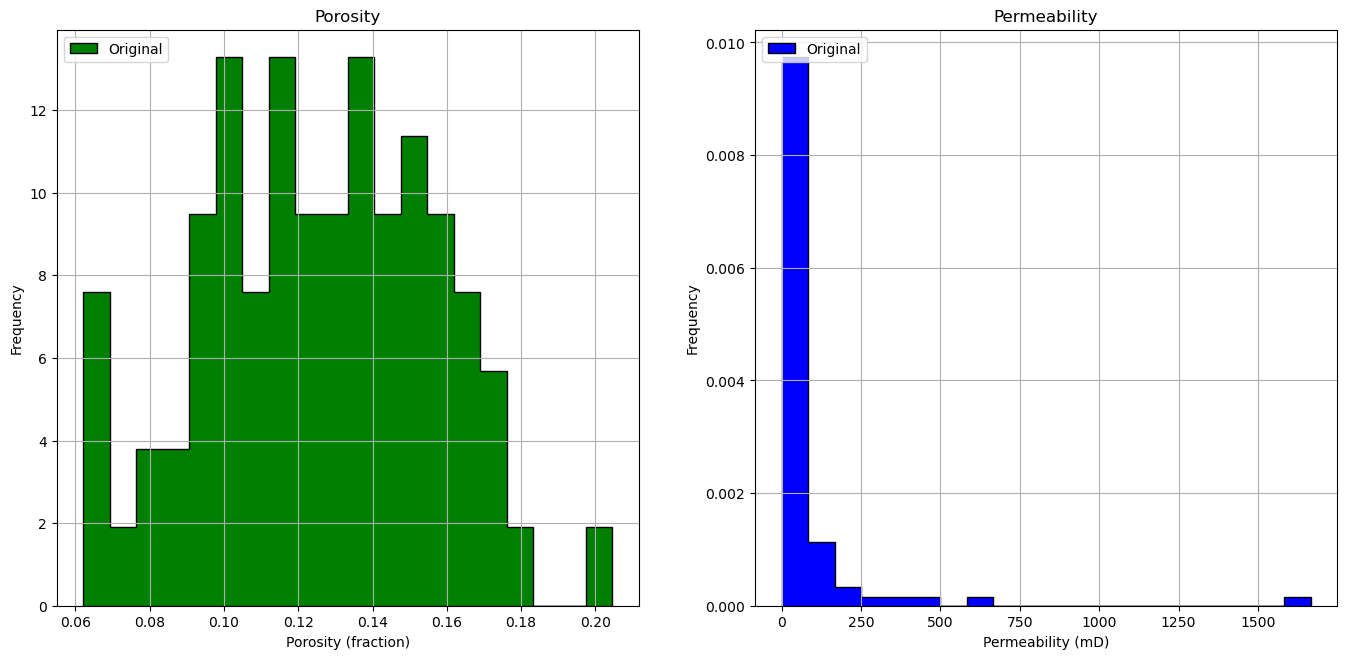

In [22]:
plt.subplot(121)                                        #plot original sand and shale porosity histograms
plt.hist(df['Porosity'], facecolor='green',bins=20,histtype="stepfilled",alpha=1,density=True,cumulative=False,edgecolor='black',label='Original')

plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(122)                                        #plot nscore transformed sand and shale histograms
plt.hist(df['Perm'], facecolor='blue',bins=20,histtype="stepfilled",alpha=1,density=True,cumulative=False,edgecolor='black',label='Original')

plt.xlabel('Permeability (mD)'); plt.ylabel('Frequency'); plt.title('Permeability')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)

#Save the image as PNG at 300 dpi
plt.savefig(os.path.join(image_path, 'kriging1.png'), dpi=300)

#Save the image as PDF
plt.savefig(os.path.join(image_path, 'kriging1.pdf'))

plt.show()

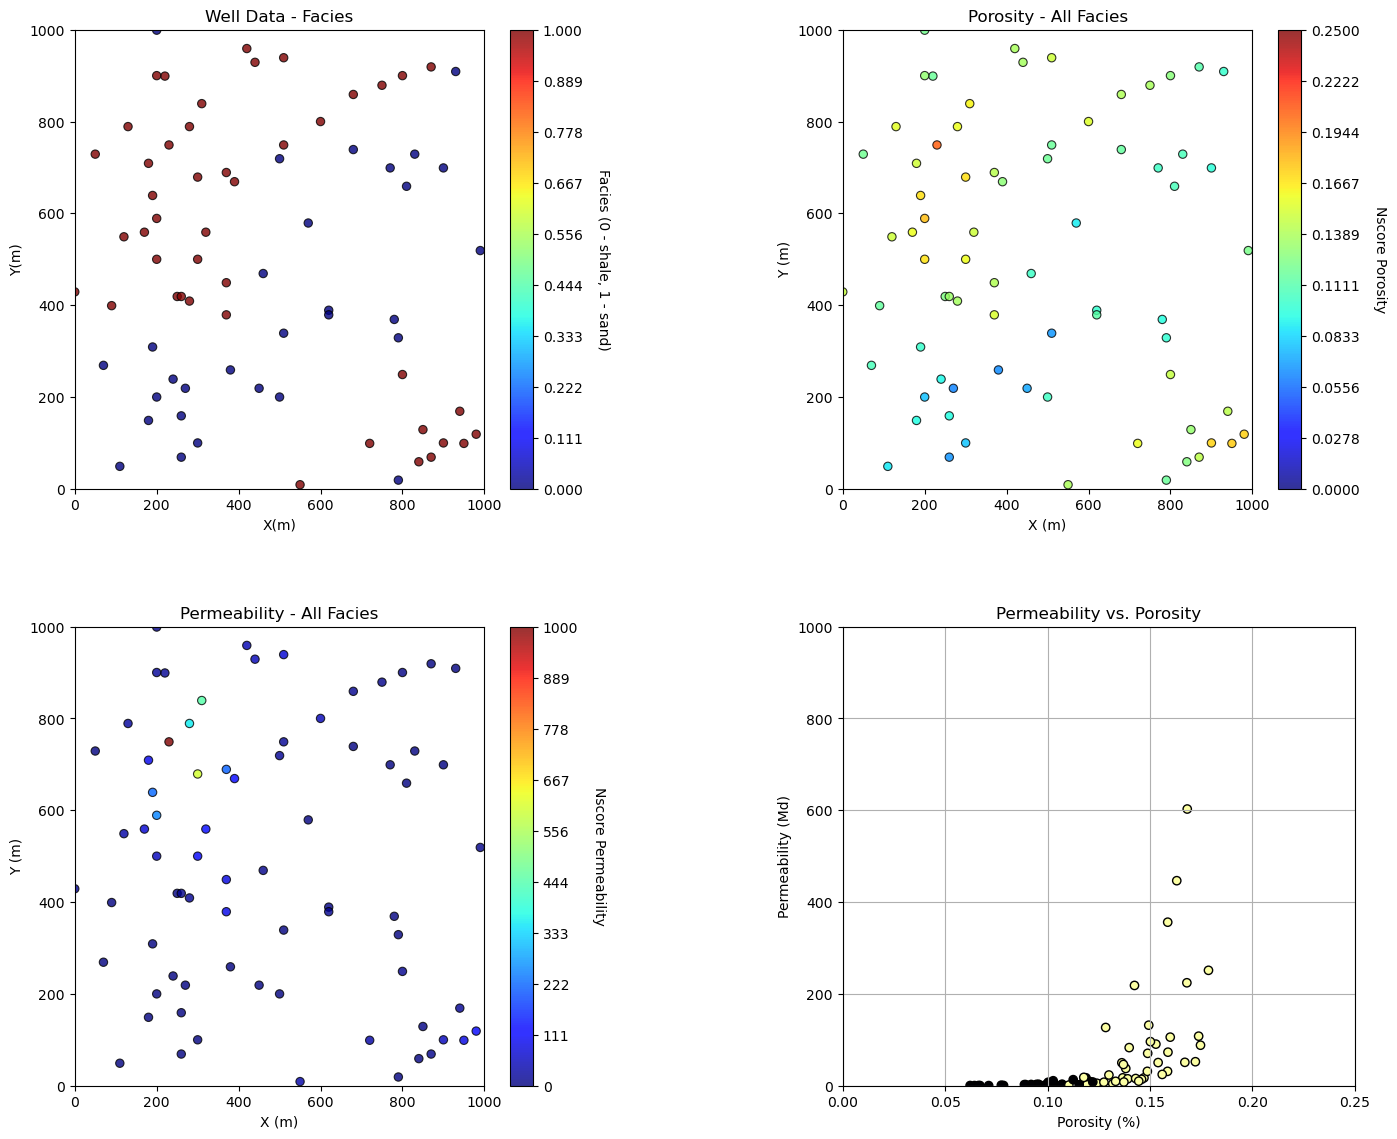

In [23]:
xmin = 0.0; xmax = 1000.0               #range of x values
ymin = 0.0; ymax = 1000.0               #range of y values

xsiz = 10; ysiz = 10                    #cell size
nx = 100; ny = 100                      #number of cells
xmn = 5; ymn = 5                        #grid origin, location center of lower left cell

cmap = plt.cm.jet                   #color map
GSLIB.locmap_st(df,'X','Y','Facies',xmin,xmax,ymin,ymax,0,1,'Well Data - Facies','X(m)','Y(m)','Facies (0 - shale, 1 - sand)',cmap)

plt.subplot(221)
GSLIB.locmap_st(df,'X','Y','Facies',xmin,xmax,ymin,ymax,0,1,'Well Data - Facies','X(m)','Y(m)','Facies (0 - shale, 1 - sand)',cmap)

plt.subplot(222)
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,0,0.25,'Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)

plt.subplot(223)
GSLIB.locmap_st(df,'X','Y','Perm',0,1000,0,1000,0,1000,'Permeability - All Facies','X (m)','Y (m)','Nscore Permeability',cmap)

plt.subplot(224)
facies = df['Facies'].values +0.01
plt.scatter(df['Porosity'],df['Perm'],c = facies,edgecolor = 'black',cmap = plt.cm.inferno)
#plt.plot([-3,3],[-3,3],color = 'black')
plt.xlabel(r'Porosity (%)')
plt.ylabel(r'Permeability (Md)')
plt.title('Permeability vs. Porosity')
plt.xlim([0,0.25])
plt.ylim([0,1000])
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.5, hspace=0.3)

#Save the image as PNG at 300 dpi
plt.savefig(os.path.join(image_path, 'kriging2.png'), dpi=300)

#Save the image as PDF
plt.savefig(os.path.join(image_path, 'kriging2.pdf'))
plt.show()

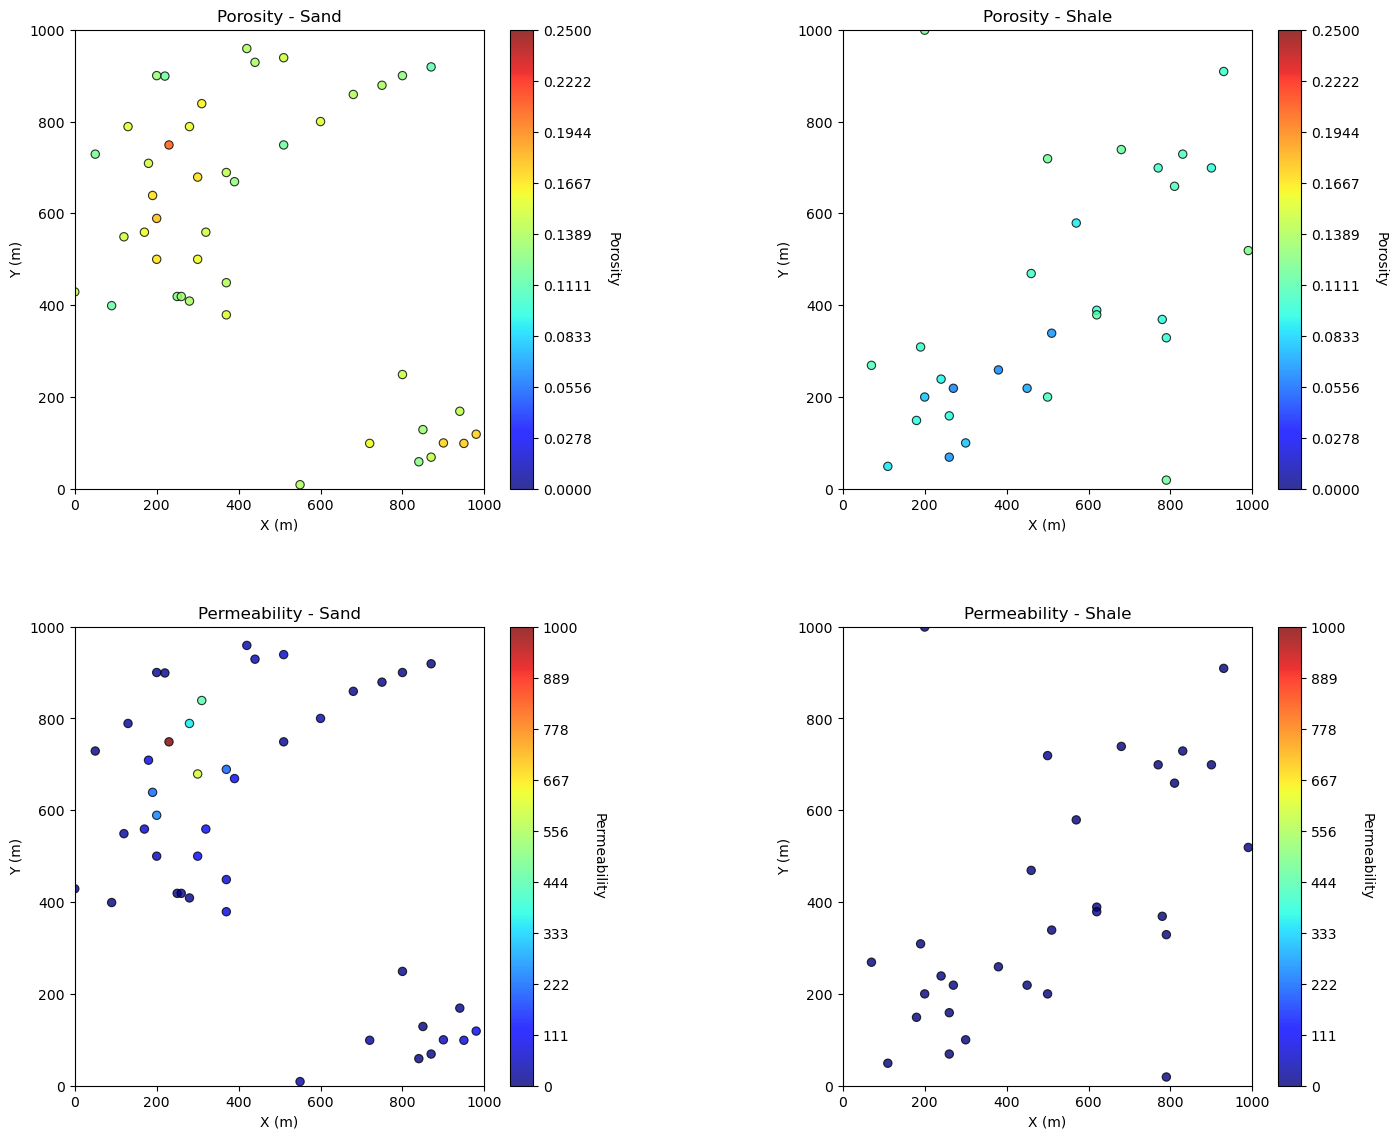

In [24]:
plt.subplot(221)
GSLIB.locmap_st(df_sand,'X','Y','Porosity',0,1000,0,1000,0,0.25,'Porosity - Sand','X (m)','Y (m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locmap_st(df_shale,'X','Y','Porosity',0,1000,0,1000,0,0.25,'Porosity - Shale','X (m)','Y (m)','Porosity',cmap)

plt.subplot(223)
GSLIB.locmap_st(df_sand,'X','Y','Perm',0,1000,0,1000,0,1000,'Permeability - Sand','X (m)','Y (m)','Permeability',cmap)

plt.subplot(224)
GSLIB.locmap_st(df_shale,'X','Y','Perm',0,1000,0,1000,0,1000,'Permeability - Shale','X (m)','Y (m)','Permeability',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.5, hspace=0.3)

#Save the image as PNG at 300 dpi
plt.savefig(os.path.join(image_path, 'kriging3.png'), dpi=300)

#Save the image as PDF
plt.savefig(os.path.join(image_path, 'kriging3.pdf'))
plt.show()

In [25]:
nxdis = 1; nydis = 1                       #block kriging discretizations, 1 for point kriging
ndmin = 0; ndmax = 40                      #minimum and maximum data for kriging 
radius = 500                               #maximum search distance
ktype = 0                                  #kriging type, 0 - simple, 1 - ordinary
ivtype = 0                                 #variable type, 0 - categorical, 1 - continuous
tmin = -999; tmax = 999;                   #data trimming limits

In [26]:
ncut = 2                                   #number of facies
thresh = [0,1]                             #the facies categories
gcdf = [0.4,0.6]                           #the global proportions of the categories
varios = []                                #the variogram list
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=500,hmin1=500)) #shale indicator variogram
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=500,hmin1=500)) #sand indicator variogram

Data for IK3D: Variable column Facies
  Number   = 74
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
   currently on estimate 1000
   currently on estimate 2000
   currently on estimate 3000
   currently on estimate 4000
   currently on estimate 5000
   currently on estimate 6000
   currently on estimate 7000
   currently on estimate 8000
   currently on estimate 9000


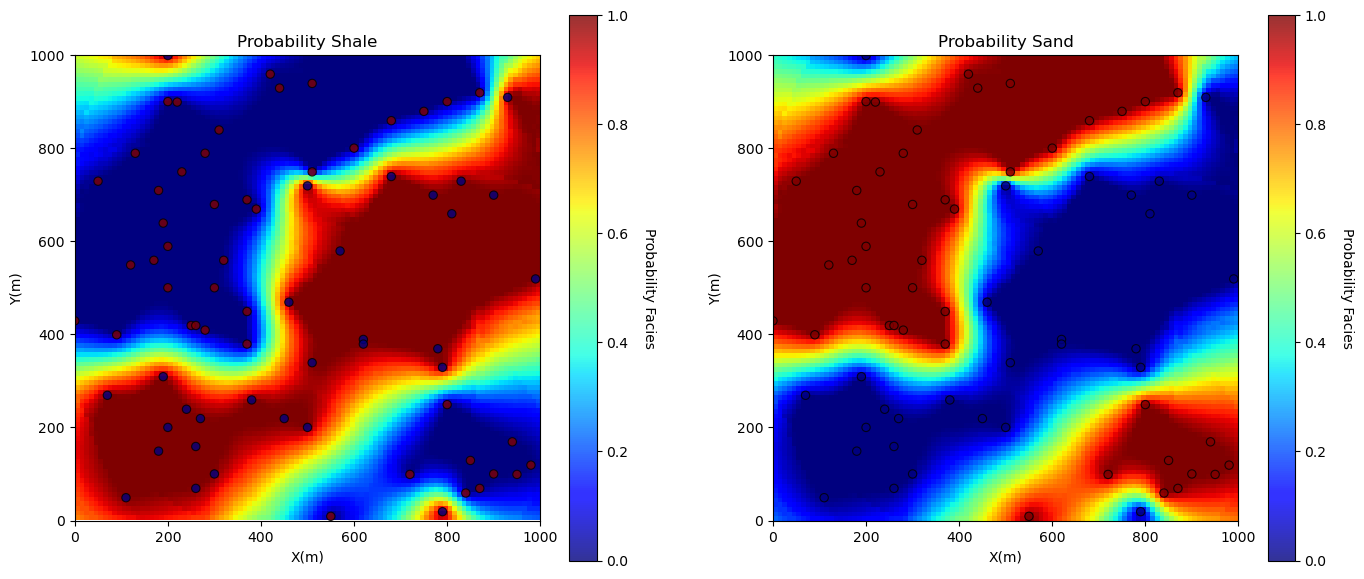

In [27]:
no_trend = np.zeros((1,1))                  #null ndarray not of correct size so ik2d will not use a trend - will fix this
ikmap = geostats.ik2d(df,'X','Y','Facies',ivtype,0,2,thresh,gcdf,no_trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz, ndmin,ndmax,radius,ktype,vario=varios)

plt.subplot(221) 
GSLIB.locpix_st(ikmap[:,:,0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Shale','X(m)','Y(m)','Probability Facies',cmap)
plt.subplot(222) 
GSLIB.locpix_st(ikmap[:,:,1],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Sand','X(m)','Y(m)','Probability Facies',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)

#Save the image as PNG at 300 dpi
plt.savefig(os.path.join(image_path, 'kriging4.png'), dpi=300)

#Save the image as PDF
plt.savefig(os.path.join(image_path, 'kriging4.pdf'))

plt.show()

In [28]:
skmean_por = 0.10; skmean_perm = 65.0      #simple kriging mean (used if simple kriging is selected below)
ktype = 0                                  #kriging type, 0 - simple, 1 - ordinary
radius = 300                               #search radius for neighbouring data
nxdis = 1; nydis = 1                       #number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 40                      #minimum and maximum data for an estimate
tmin = 0.0                                 #minimum property value
por_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=45,hmaj1=300,hmin1=300) #porosity variogram

In [29]:
skmean_por_sand = 0.10; skmean_por_shale = 0.08
skmean_perm_sand = 3.0; skmean_perm_shale = 0.5

por_sand_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=500,hmin1=500) #porosity sand variogram
por_shale_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=500,hmin1=500) #porosity shale variogram

#perm_sand_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100) #perm sand variogram
#perm_shale_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=10,hmin1=10) #perm shale variogram

facies_kmap = np.zeros((ny,nx)); por_kmap = np.zeros((ny,nx)); perm_kmap = np.zeros((ny,nx)) # declare array to combine values

  Estimated   10000 blocks 
      average   0.11811465397054353  variance  0.0006000202795742801


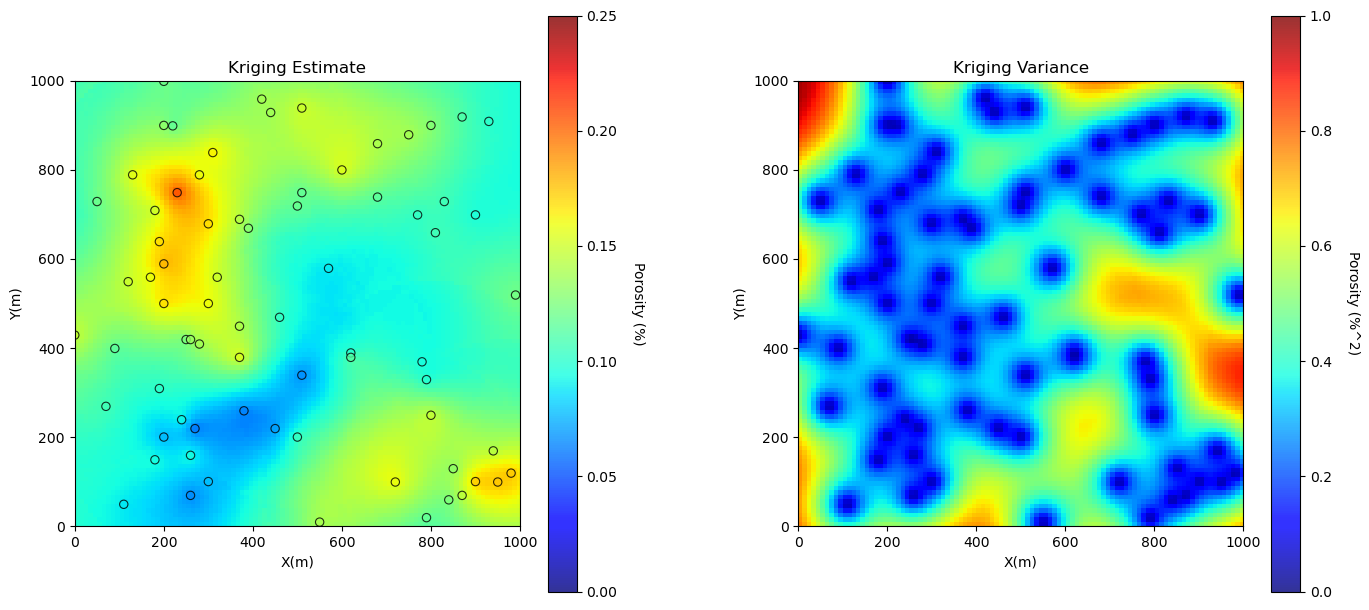

In [30]:
por_kmap, por_vmap = geostats.kb2d(df,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por,por_vario)

#perm_kmap, perm_vmap = geostats.kb2d(df,'X','Y','Perm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
#          ndmin,ndmax,radius,ktype,skmean_perm,por_vario)

plt.subplot(121)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df,'X','Y','Porosity','Kriging Estimate','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(122)
GSLIB.pixelplt_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance','X(m)','Y(m)','Porosity (%^2)',cmap)

# plt.subplot(223)
# GSLIB.locpix_st(perm_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,1000,df,'X','Y','Perm','Kriging Estimate','X(m)','Y(m)','Permeability (mD)',cmap)

# plt.subplot(224)
# GSLIB.pixelplt_st(perm_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance','X(m)','Y(m)','Permeability (mD^2)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.3, hspace=0.3)

#Save the image as PNG at 300 dpi
plt.savefig(os.path.join(image_path, 'kriging5.png'), dpi=300)

#Save the image as PDF
plt.savefig(os.path.join(image_path, 'kriging5.pdf'))
plt.show()

In [31]:
skmean_por_sand = 0.10; skmean_por_shale = 0.08
skmean_perm_sand = 3.0; skmean_perm_shale = 0.5

por_sand_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=500,hmin1=500) # porosity sand variogram
por_shale_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=500,hmin1=500) # porosity shale variogram

# perm_sand_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100) # perm sand variogram
# perm_shale_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=10,hmin1=10) # perm shale variogram

facies_kmap = np.zeros((ny,nx)); por_kmap = np.zeros((ny,nx)); perm_kmap = np.zeros((ny,nx)) # declare array to combine values

  Estimated   10000 blocks 
      average   0.13047612897254043  variance  0.00031954238741583804
  Estimated   10000 blocks 
      average   0.09894517270299363  variance  0.00012543322496456726


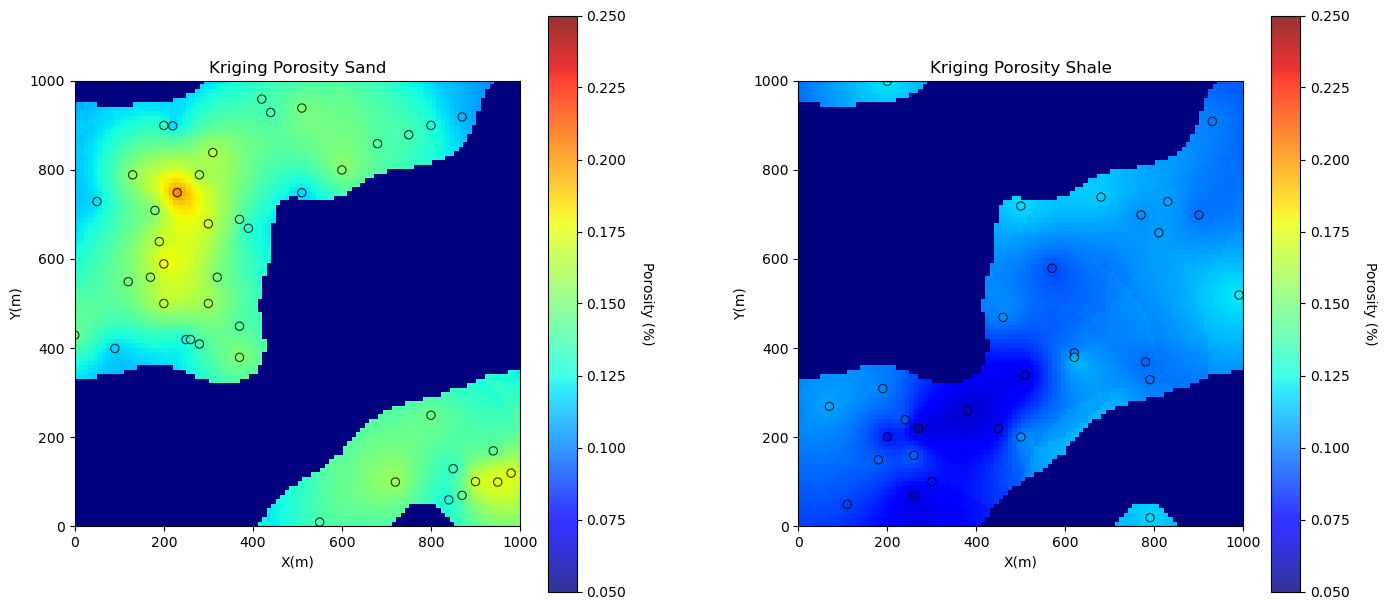

In [32]:
por_sand_kmap, por_sand_vmap = geostats.kb2d(df_sand,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por_sand,por_sand_vario)


por_shale_kmap, por_shale_vmap = geostats.kb2d(df_shale,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por_shale,por_shale_vario)

for iy in range(0,ny):
    for ix in range(0,nx):
        if ikmap[iy,ix,1] > 0.5:   # current location is assumed to be sand
            facies_kmap[iy,ix] = 1
            por_kmap[iy,ix] = por_sand_kmap[iy,ix];
#            perm_kmap[iy,ix] = perm_sand_kmap[iy,ix];
            por_shale_kmap[iy,ix] = -1
#            perm_shale_kmap[iy,ix] = -1
        else:                      # current location is assumed to be shale
            facies_kmap[iy,ix] = 0
            por_kmap[iy,ix] = por_shale_kmap[iy,ix];
#            perm_kmap[iy,ix] = perm_shale_kmap[iy,ix];
            por_sand_kmap[iy,ix] = -1
#            perm_sand_kmap[iy,ix] = -1

plt.subplot(121)
GSLIB.locpix_st(por_sand_kmap,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df_sand,'X','Y','Porosity','Kriging Porosity Sand','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(122)
GSLIB.locpix_st(por_shale_kmap,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df_shale,'X','Y','Porosity','Kriging Porosity Shale','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.3, hspace=0.3)

#Save the image as PNG at 300 dpi
plt.savefig(os.path.join(image_path, 'kriging6.png'), dpi=300)

#Save the image as PDF
plt.savefig(os.path.join(image_path, 'kriging6.pdf'))
plt.show()

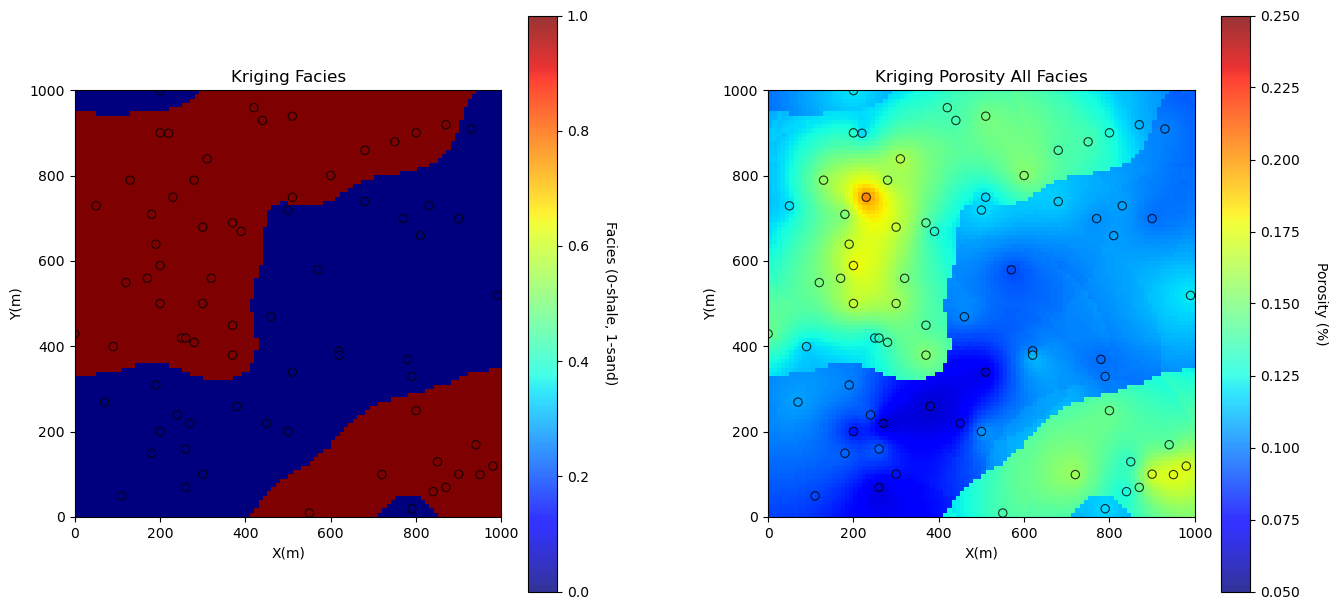

In [33]:
plt.subplot(131)
GSLIB.locpix_st(facies_kmap,xmin,xmax,ymin,ymax,xsiz,0,1,df,'X','Y','Facies','Kriging Facies','X(m)','Y(m)','Facies (0-shale, 1-sand)',cmap)

plt.subplot(132)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Kriging Porosity All Facies','X(m)','Y(m)','Porosity (%)',cmap)

# plt.subplot(133)
# GSLIB.locpix_st(perm_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,1000,df,'X','Y','Perm','Kriging Permeability All Facies','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.3, hspace=0.3)

#Save the image as PNG at 300 dpi
plt.savefig(os.path.join(image_path, 'kriging7.png'), dpi=300)

#Save the image as PDF
plt.savefig(os.path.join(image_path, 'krigging7.pdf'))
plt.show()

In [34]:
#Perform Kriging
por_kmap, por_vmap = geostats.kb2d(df,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por,por_vario)

#Define the path for saving the results file
results_file_path = os.path.join(results_path, 'kriging_results.csv')

#Open a CSV file for writing
import csv
with open(results_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

    #Write the header row
    header = ['X', 'Y', 'por_kmap', 'por_vmap']
    csv_writer.writerow(header)

    #Write the kriging results for each location
    for i in range(len(df)):
        x = df.loc[i, 'X']
        y = df.loc[i, 'Y']
        porosity_kriging = por_kmap[i]
        porosity_variance = por_vmap[i]
        row = [x, y, porosity_kriging, porosity_variance]
        csv_writer.writerow(row)

  Estimated   10000 blocks 
      average   0.11811465397054353  variance  0.0006000202795742801


 ## Question 6: Kriging Efficiency Calculation

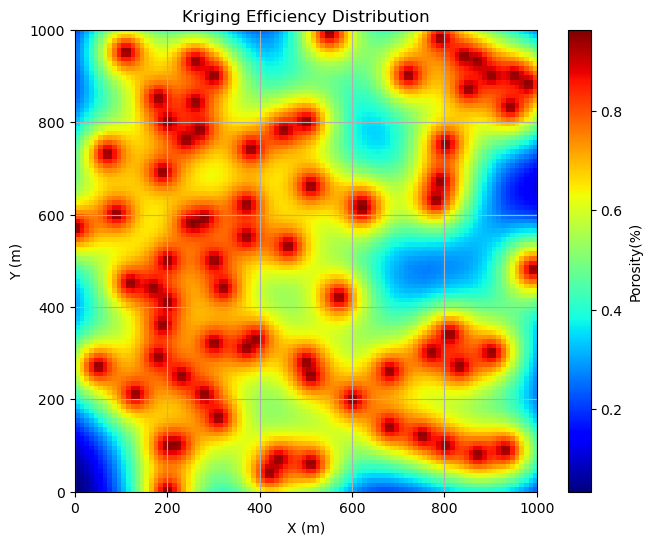

In [35]:
#Calculate the Kriging Efficiency 
bvar = 1.0  
keff_map = (bvar - por_vmap) / bvar

#Visualize the KEFF distribution as a 2D spatial plot
plt.figure(figsize=(8, 6))
plt.imshow(keff_map, extent=[xmin, xmax, ymin, ymax], origin='lower', cmap='jet')
plt.colorbar(label='Porosity(%)')
plt.title('Kriging Efficiency Distribution')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.grid(True)
plt.show()

## Question 7: Interpolation Method Comparison

When compared to IDW with powers 2 and 3, Kriging has been proven as the more accurate interpolation method. This is because of its ability to capture spatial correlation by incorporating variogram analysis while ensuring point data reproducibility. Kriging's comprehensive variogram modelling allows for a thorough understanding of how nearby data points influence each other resulting in estimates that closely resemble actual spatial relationships within the dataset. On the other hand, IDW, especially with power values 2 and 3, offers a simpler representation of spatial correlation, making it less effective in complex scenarios.

The results of the interpolation methods show that the differences in accuracy are relatively minor. While Kriging demonstrates slightly better performance in terms of lower average estimation error and variance, the disparities between Kriging and IDW with powers 2 and 3 are not significant. The average estimation errors for all methods are in close proximity, with variations within a small decimal range. Similarly, the variances exhibit only slight differences. Therefore, these subtle variations may not be decisive in choosing an interpolation method for practical applications.

When selecting an interpolation method, factors beyond slight variations in accuracy should be considered. Practical factors such as computational efficiency and ease of implementation are important. IDW's simplicity makes it favourable for rapid and straightforward evaluations, while Kriging is better suited for meticulous spatial analysis, potentially requiring more computational resources, depending on available software and resources. Consequently, a combination of both methods or the use of one over the other depends on the specific project needs and dataset characteristics. While Kriging offers slightly higher accuracy, the differences between Kriging and IDW (powers 2 and 3) are minimal.